### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [39]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
433,PSID249,0,19,3,0,0,1,1,0.00000,537.0968,0.00000
380,PSID196,0,18,11,1,0,0,1,0.00000,1367.8060,33.98771
141,NSW142,1,25,12,1,0,0,0,14426.79000,2409.2740,0.00000
88,NSW89,1,21,12,0,0,0,0,0.00000,0.0000,8048.60300
322,PSID138,0,39,10,0,0,1,1,0.00000,2886.0000,18761.22000
10,NSW11,1,19,9,1,0,0,1,0.00000,0.0000,8173.90800
346,PSID162,0,50,3,0,0,1,1,3136.78600,2203.8870,13976.34000
524,PSID340,0,23,12,0,0,0,0,1504.71700,0.0000,0.00000
295,PSID111,0,51,11,0,0,0,1,48.98167,3813.3870,1525.01400
64,NSW65,1,29,4,1,0,0,1,0.00000,0.0000,762.91460


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

C:\Users\gerry\AppData\Local\Temp\ipykernel_11364\3625356907.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


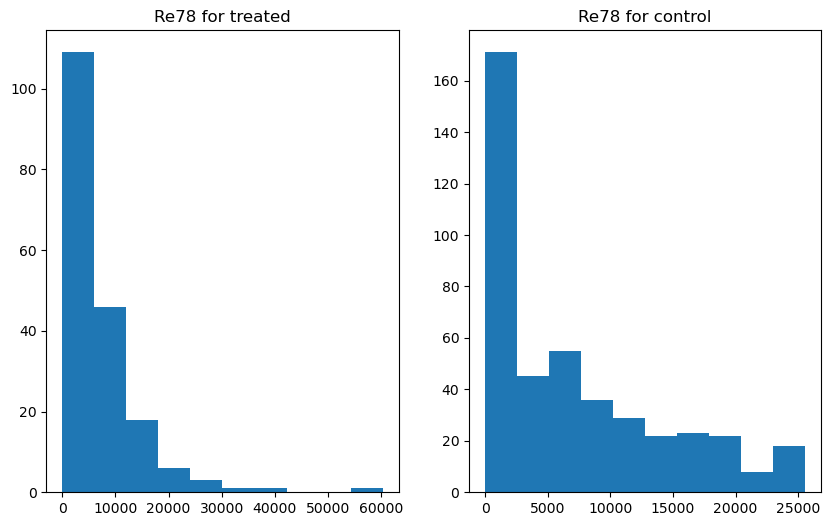

In [27]:
''' your code and explanations '''
treated = df.query("treat == 1")
control = df.query("treat == 0")
groups = ['treated', 'control']

fig, ax = plt.subplots(1,2,figsize = (10,6))
for i, group in enumerate((treated,control)):
    ax[i].hist(group['re78'])
    ax[i].set_title(f'Re78 for {groups[i]}')
fig.show()

C:\Users\gerry\AppData\Local\Temp\ipykernel_11364\2489181503.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


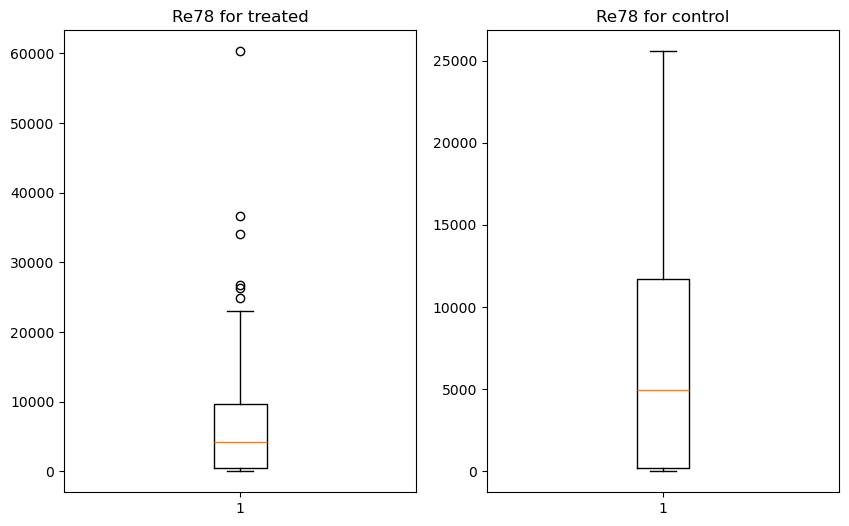

In [6]:
fig, ax = plt.subplots(1,2,figsize = (10,6))
for i, group in enumerate((treated,control)):
    ax[i].boxplot(group['re78'])
    ax[i].set_title(f'Re78 for {groups[i]}')
fig.show()

In [7]:
treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [8]:
control['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

C:\Users\gerry\AppData\Local\Temp\ipykernel_11364\3179685800.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


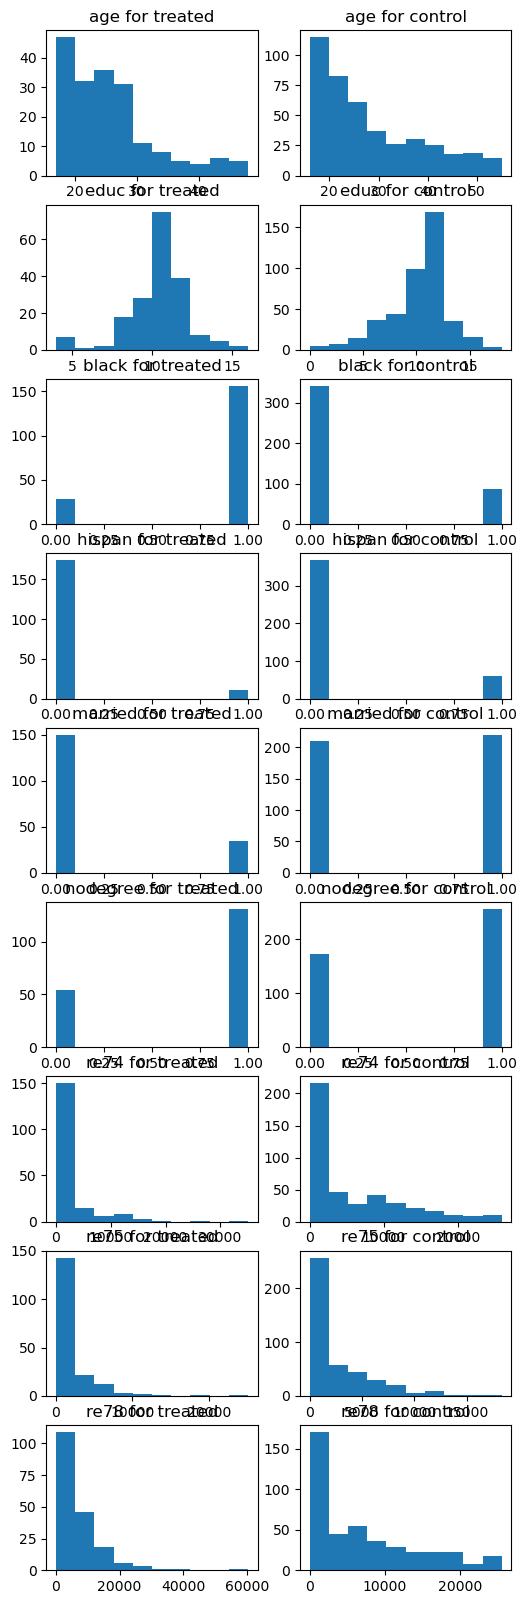

In [38]:
''' your code and explanations '''
variables = df.columns[2:].to_list()
fig, ax = plt.subplots(9,2,figsize = (6,20))
for i, var in enumerate(variables):
    for j, group in enumerate((treated,control)):
        ax[i][j].hist(group[var])
        ax[i][j].set_title(f'{var} for {groups[j]}')
fig.show()

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [44]:
''' your code and explanations '''
df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['re74'] = (df['re74'] - df['re74'].mean()) / df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean()) / df['re75'].std()
df['re78'] = (df['re78'] - df['re78'].mean()) / df['re78'].std()
model = smf.logit(formula='treat  ~ age + C(educ) + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75 + re78', data=df)

res = model.fit()
df['prop_score'] = res.predict()
print(res.summary())

         Current function value: 0.384998
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      588
Method:                           MLE   Df Model:                           25
Date:                Mon, 06 Jan 2025   Pseudo R-squ.:                  0.3709
Time:                        10:46:08   Log-Likelihood:                -236.39
converged:                      False   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 1.087e-44
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -8.2221   2.95e+06  -2.78e-06      1.000   -5.79e+06    5.79e+06
C(educ)[T.1]       -30.7009   4.13e+09  -7.43e-

c:\Users\gerry\anaconda3\envs\ada\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [55]:
''' your code and explanations '''
G = nx.Graph()

treated = df.query('treat == 1')
control = df.query('treat == 0')

def similarity_meas(prop_treat, prop_control):
    return 1 - np.abs(prop_treat - prop_control)

for i, treat_row in treated.iterrows():
    for j, control_row in control.iterrows():
        G.add_weighted_edges_from([(i, j, similarity_meas(treat_row['prop_score'],control_row['prop_score']))])

matching = nx.max_weight_matching(G)

In [63]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

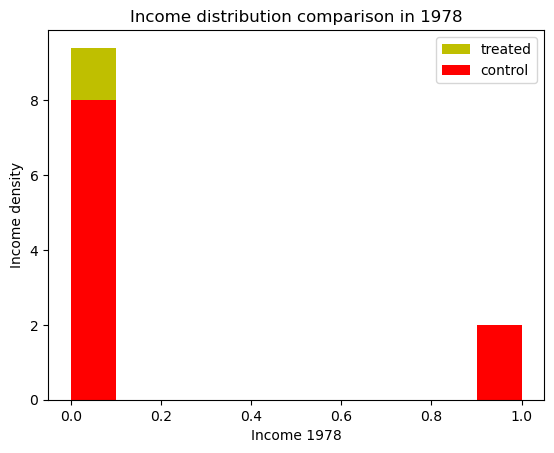

In [71]:
balanced_df = df.iloc[matched]
colors = ['y','r']


for i, group in enumerate([balanced_df.query('treat == 1'),balanced_df.query('treat == 0')]):
    ax = plt.hist(group['hispan'], 10, density=True, histtype='bar', color=colors[i], label=f'{groups[i]}')
plt.title('Income distribution comparison in 1978')
plt.xlabel('Income 1978')
plt.ylabel('Income density')
plt.legend()

IndexError: index 2 is out of bounds for axis 1 with size 2

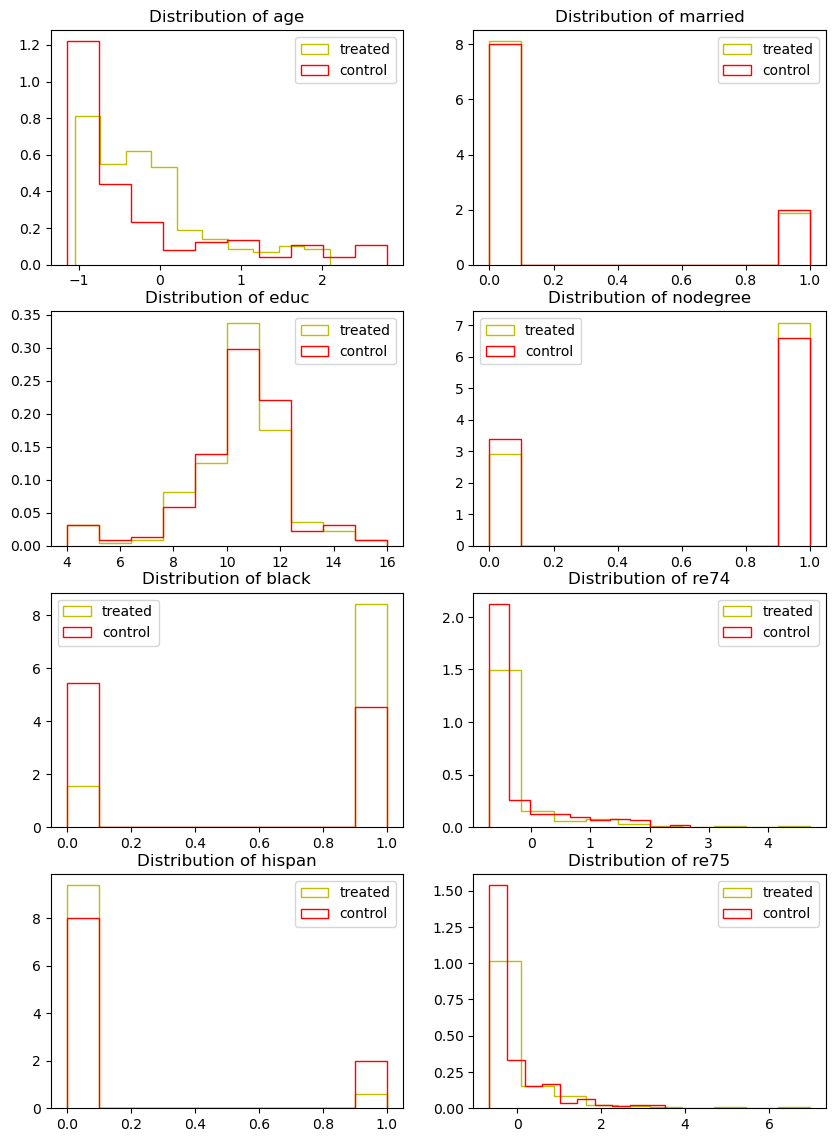

In [73]:
import math
fig, ax = plt.subplots(4,2,figsize = (10,14))
for j, var in enumerate(variables):
    for i, group in enumerate([balanced_df.query('treat == 1'),balanced_df.query('treat == 0')]):
        sbplt = ax[j%4, math.floor(j/4)] # 4 = numb of rows
        sbplt.hist(group[var], 10, density=True, histtype='step', color=colors[i], label=f'{groups[i]}')
        sbplt.set_title(f'Distribution of {var}')
        sbplt.legend()

We can see that the distributions are mainly similar except for race -- fix balck and hispan

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [79]:
''' your code and explanations '''

G = nx.Graph()

treated = df.query('treat == 1')
control = df.query('treat == 0')

def similarity_meas(prop_treat, prop_control):
    return 1 - np.abs(prop_treat - prop_control)

for i, treat_row in treated.iterrows():
    for j, control_row in control.iterrows():
        if (treat_row['black'] == control_row['black'] and \
            treat_row['hispan'] == control_row['hispan']):
            G.add_weighted_edges_from([(i, j, similarity_meas(treat_row['prop_score'],control_row['prop_score']))])

matching = nx.max_weight_matching(G)

In [80]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_fix = df.iloc[matched]

IndexError: index 2 is out of bounds for axis 1 with size 2

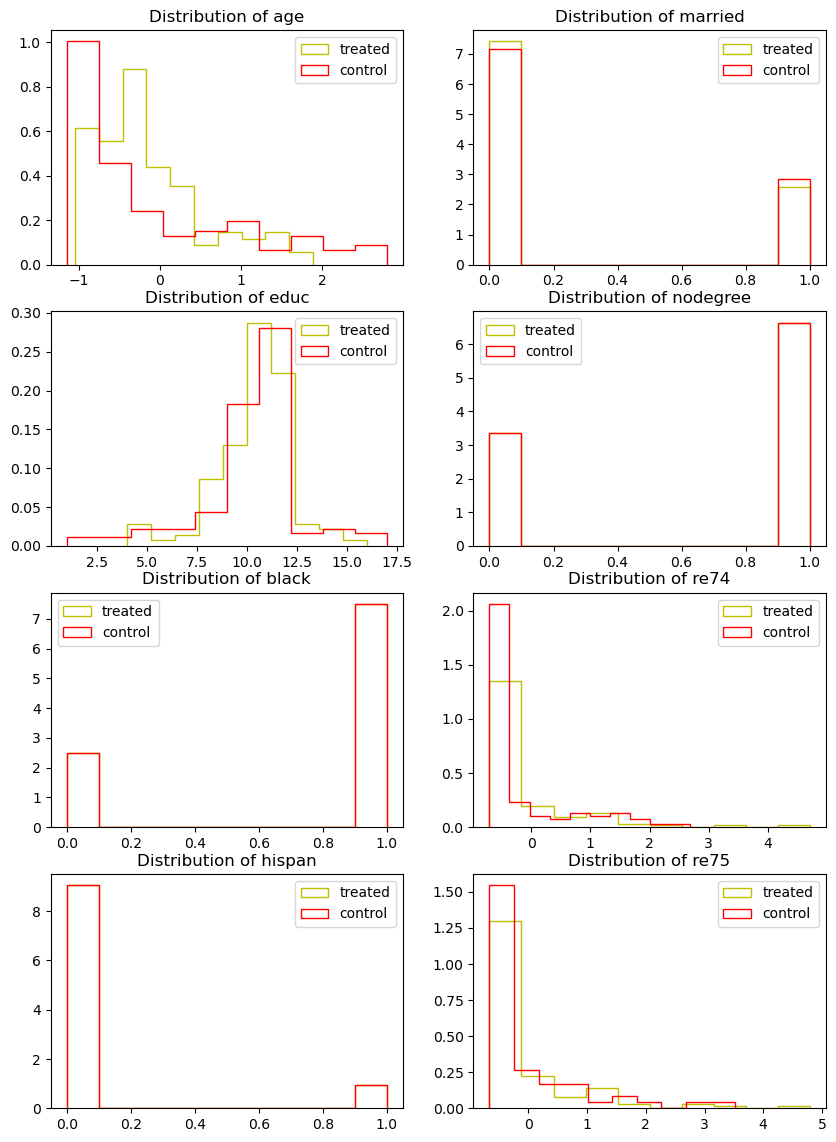

In [81]:
fig, ax = plt.subplots(4,2,figsize = (10,14))
for j, var in enumerate(variables):
    for i, group in enumerate([balanced_df_fix.query('treat == 1'),balanced_df_fix.query('treat == 0')]):
        sbplt = ax[j%4, math.floor(j/4)] # 4 = numb of rows
        sbplt.hist(group[var], 10, density=True, histtype='step', color=colors[i], label=f'{groups[i]}')
        sbplt.set_title(f'Distribution of {var}')
        sbplt.legend()

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [9]:
''' your code and explanations ''';